### Testing cloud-cover detection with a clear-sky LWd ensemble @ CUES

Estimate the clear-sky downward longwave using several different methods. Test these functions, and then compare the ensemble mean clear-sky downward longwave (LWd) to measured LWd at the CUES site to try and identify cloud-cover. We expect observed LWd to be greater than estimated clear-sky LWd when we have cloud-cover. This should be especially useful for identifying cloud-cover during nighttime when we don't have shortwave solar radiation to also check if we have sunny or cloudy skies. We can take a look at the GOES-16 ABI IR observations from the same time, where we expect to see cold cloud-tops when they pass over the site.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import datetime as dt
import xarray as xr
from scipy import stats

%matplotlib inline

Import the clear-sky downward longwave functions:

In [2]:
import lw_clr

In [3]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    # https://thispointer.com/python-how-to-get-list-of-files-in-directory-and-sub-directories/
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles 

---
# Test the LW functions:

Load observations from CUES site:

In [4]:
cues_ds = pd.read_pickle('CUES_L1_Temp_Rad_2017-2019.pkl').to_xarray()

Load GOES observations for the CUES site

In [5]:
directory = r'\\j-lundquist-3.ce.washington.edu\storage\GOES\pkl\CUES'
goes_files = getListOfFiles(directory)

goes = []
_ = [goes.append(pd.read_pickle(i)) for i in goes_files]
goes = pd.concat(goes)

# Change GOES time values from UTC to UTC-7 for CUES site:
goes = goes.rename(columns={'time': 'timeUTC'})
goes['datetime'] = goes['timeUTC'] - pd.Timedelta(hours=7)
goes = goes.drop(columns=['timeUTC'])

# Convert pandas dataframe to xarray dataset and and make our local time datetimes the index
_goes = goes.set_index('datetime')
_goes.sort_index(inplace=True)
_goes = _goes.loc[~_goes.index.duplicated(keep='first')] # there are duplicates somewhere in the GOES data, remove them
_goes = _goes.loc[_goes.index >= pd.datetime(2017,2,28)]# there's also some values before 2017, remove them
goes_ds = _goes.to_xarray()

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.


#### Run ensemble of all these LW estimation methods:

Set up input variables from CUES observations (resampled to 1 hour means):

In [6]:
RH = cues_ds['Platform relative humidity; platform temperature/relative humidity; (percent)']#.resample(datetime='1H').mean()
T = cues_ds['Platform temperature; platform temperature/relative humidity; (degrees Celsius)']#.resample(datetime='1H').mean()
Ta = T + 273.15 # temperature [K]
Ta = Ta.where((Ta>250)&(Ta<300)) # I noticed some erroneous looking temperature values in Sept. 2018, try filtering those out here
Qsi = cues_ds['upward looking solar radiation; uplooking Eppley Lab precision spectral pyranometer; (Watts/meter^2)']#.resample(datetime='1H').mean()
elev = 2940 # meters

Run the ensemble function

In [7]:
lw_ensemble = lw_clr.ensemble(Ta, RH, elev)

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\xarray\core\nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Add all the results to the CUES dataset:

In [8]:
cues_ds = xr.merge([cues_ds, lw_ensemble])

---
# Plot results:

Set up font sizes for plot

In [9]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

For each estimation method, plot the estimated clear-sky LWd versus observed all-sky LWd:

In [10]:
# Function for making these plots
def plot_2dhist_LWensemble(x,y_,row,col):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=200)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax[row,col].imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax[row,col].plot([0,400],[0,400],'-',c='grey')
    ax[row,col].text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax[row,col].text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax[row,col].set_xlim([100,400])
    ax[row,col].set_ylim([100,400])
    ax[row,col].set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax[row,col].set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax[row,col].set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

def plot_2dhist_LW(x,y_):
    # Drop NaN values between the two datasets
    df1 = pd.DataFrame({'x': x})
    df1['y'] = y_
    #df1.fillna(df1.mean(), inplace=True) # filling nan with the mean so I can keep the same shape as I start with
    df1 = df1.dropna()
    x = df1.x
    y = df1.y

    # Fit a linear function to x and y
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    fit = slope*x + intercept

    # Make "heatmap" 2d histogram
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    # Plot heatmap
    ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='Greys')
    # Add colorbar
    #ax[row,col].colorbar(label='number of records')
    #plt.plot(x, fit, ':r')
    #plt.plot(x,y,'.k',alpha=0.05)
    ax.plot([0,400],[0,400],'-',c='grey')
    ax.text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
    ax.text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
    ax.set_xlim([100,400])
    ax.set_ylim([100,400])
    ax.set_ylabel('LWd Estimated [$Wm^{-2}$]')
    ax.set_xlabel('LWd Observed [$Wm^{-2}$]');
    ax.set_title('LWd Observed vs\n {}'.format(y_.name))
    return None

In [11]:
x = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
y = [cues_ds.lclr_angstrom1918,cues_ds.lclr_brunt1932,cues_ds.lclr_brutsaert1975,cues_ds.lclr_garratt1992,
     cues_ds.lclr_idsojackson1969, cues_ds.lclr_idso1981,cues_ds.lclr_iziomon2003,cues_ds.lclr_keding1989,
     cues_ds.lclr_niemela2001,cues_ds.lclr_prata1996,cues_ds.lclr_satturlund1979,cues_ds.lclr_swinbank1963,
     cues_ds.lclr_dilleyobrien1998,cues_ds.lclr_maykutchurch1973,
     cues_ds.lclr_campbellnorman1998,cues_ds.lclr_ohmura1982,cues_ds.lclr_efimova1961,
     cues_ds.lclr_mean, cues_ds.lclr_min, cues_ds.lclr_max]

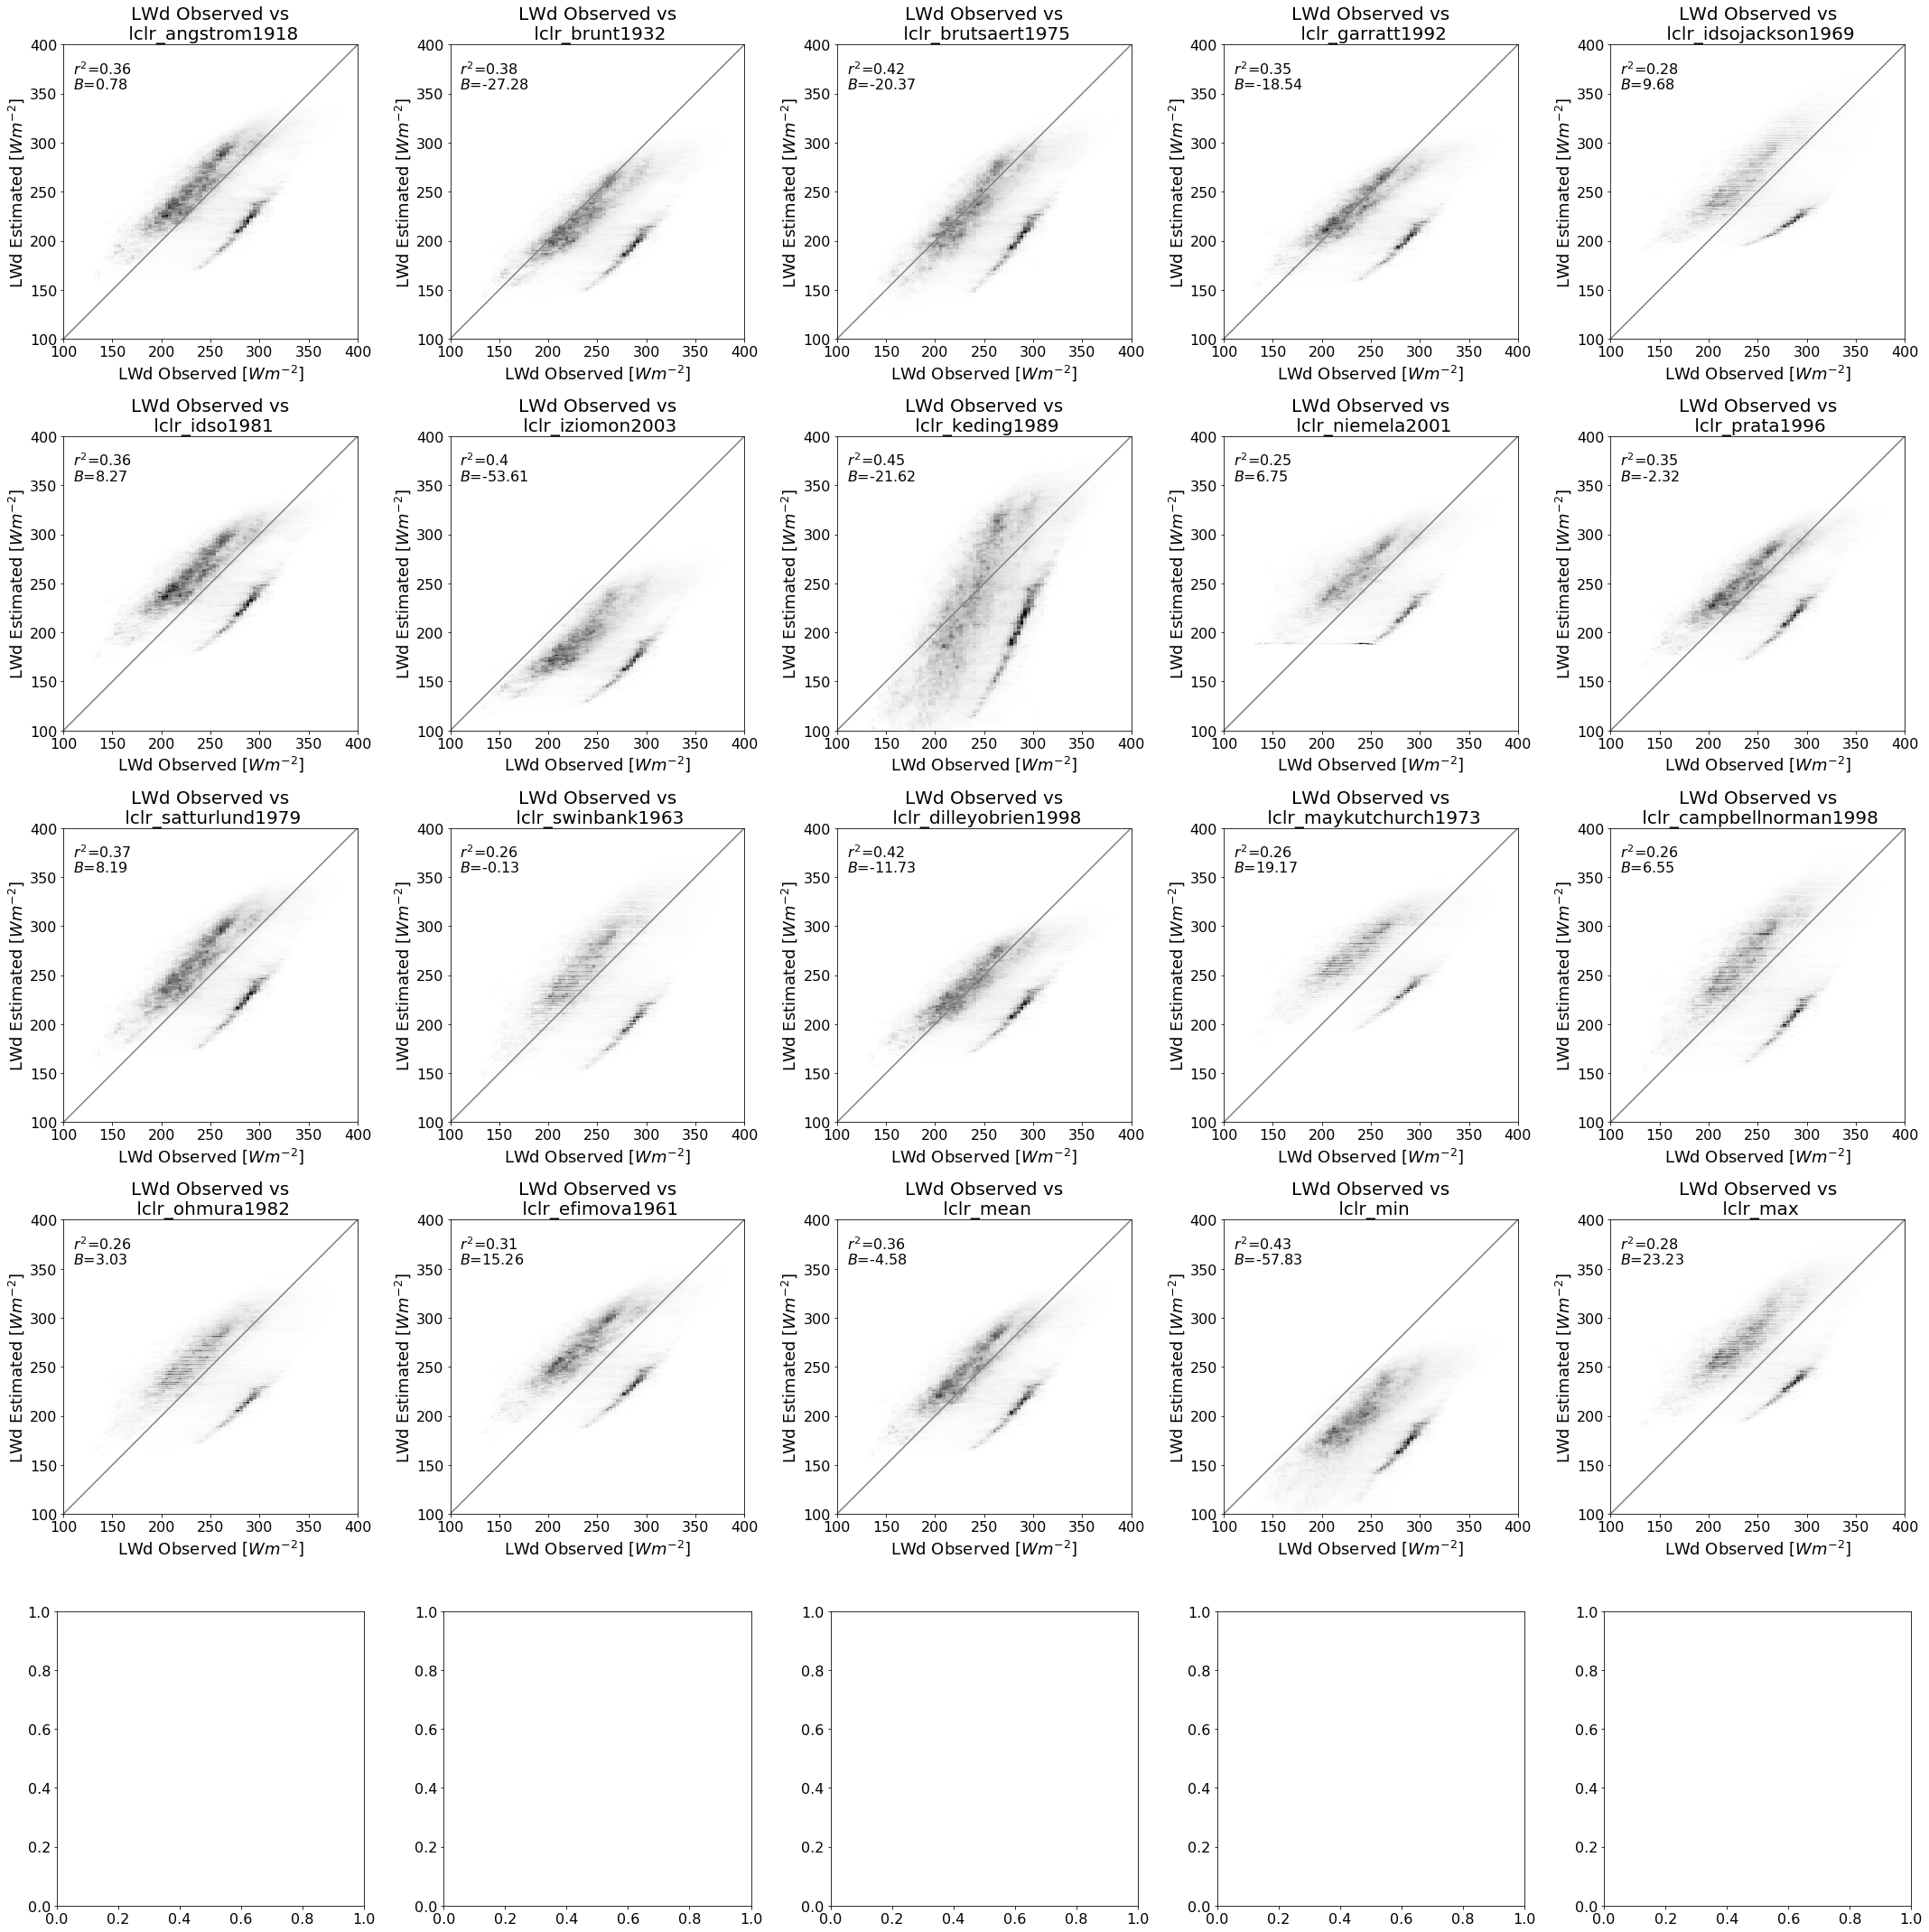

In [12]:
fig, ax = plt.subplots(5,5,figsize=(30,30))
for row in range(0,5):
    for col in range(0,5):
        try:
            plot_2dhist_LWensemble(x,y[(row*5)+col],row,col)
        except IndexError:
            pass
plt.tight_layout()

Plot only for clear-sky conditions (sun flag = 1)

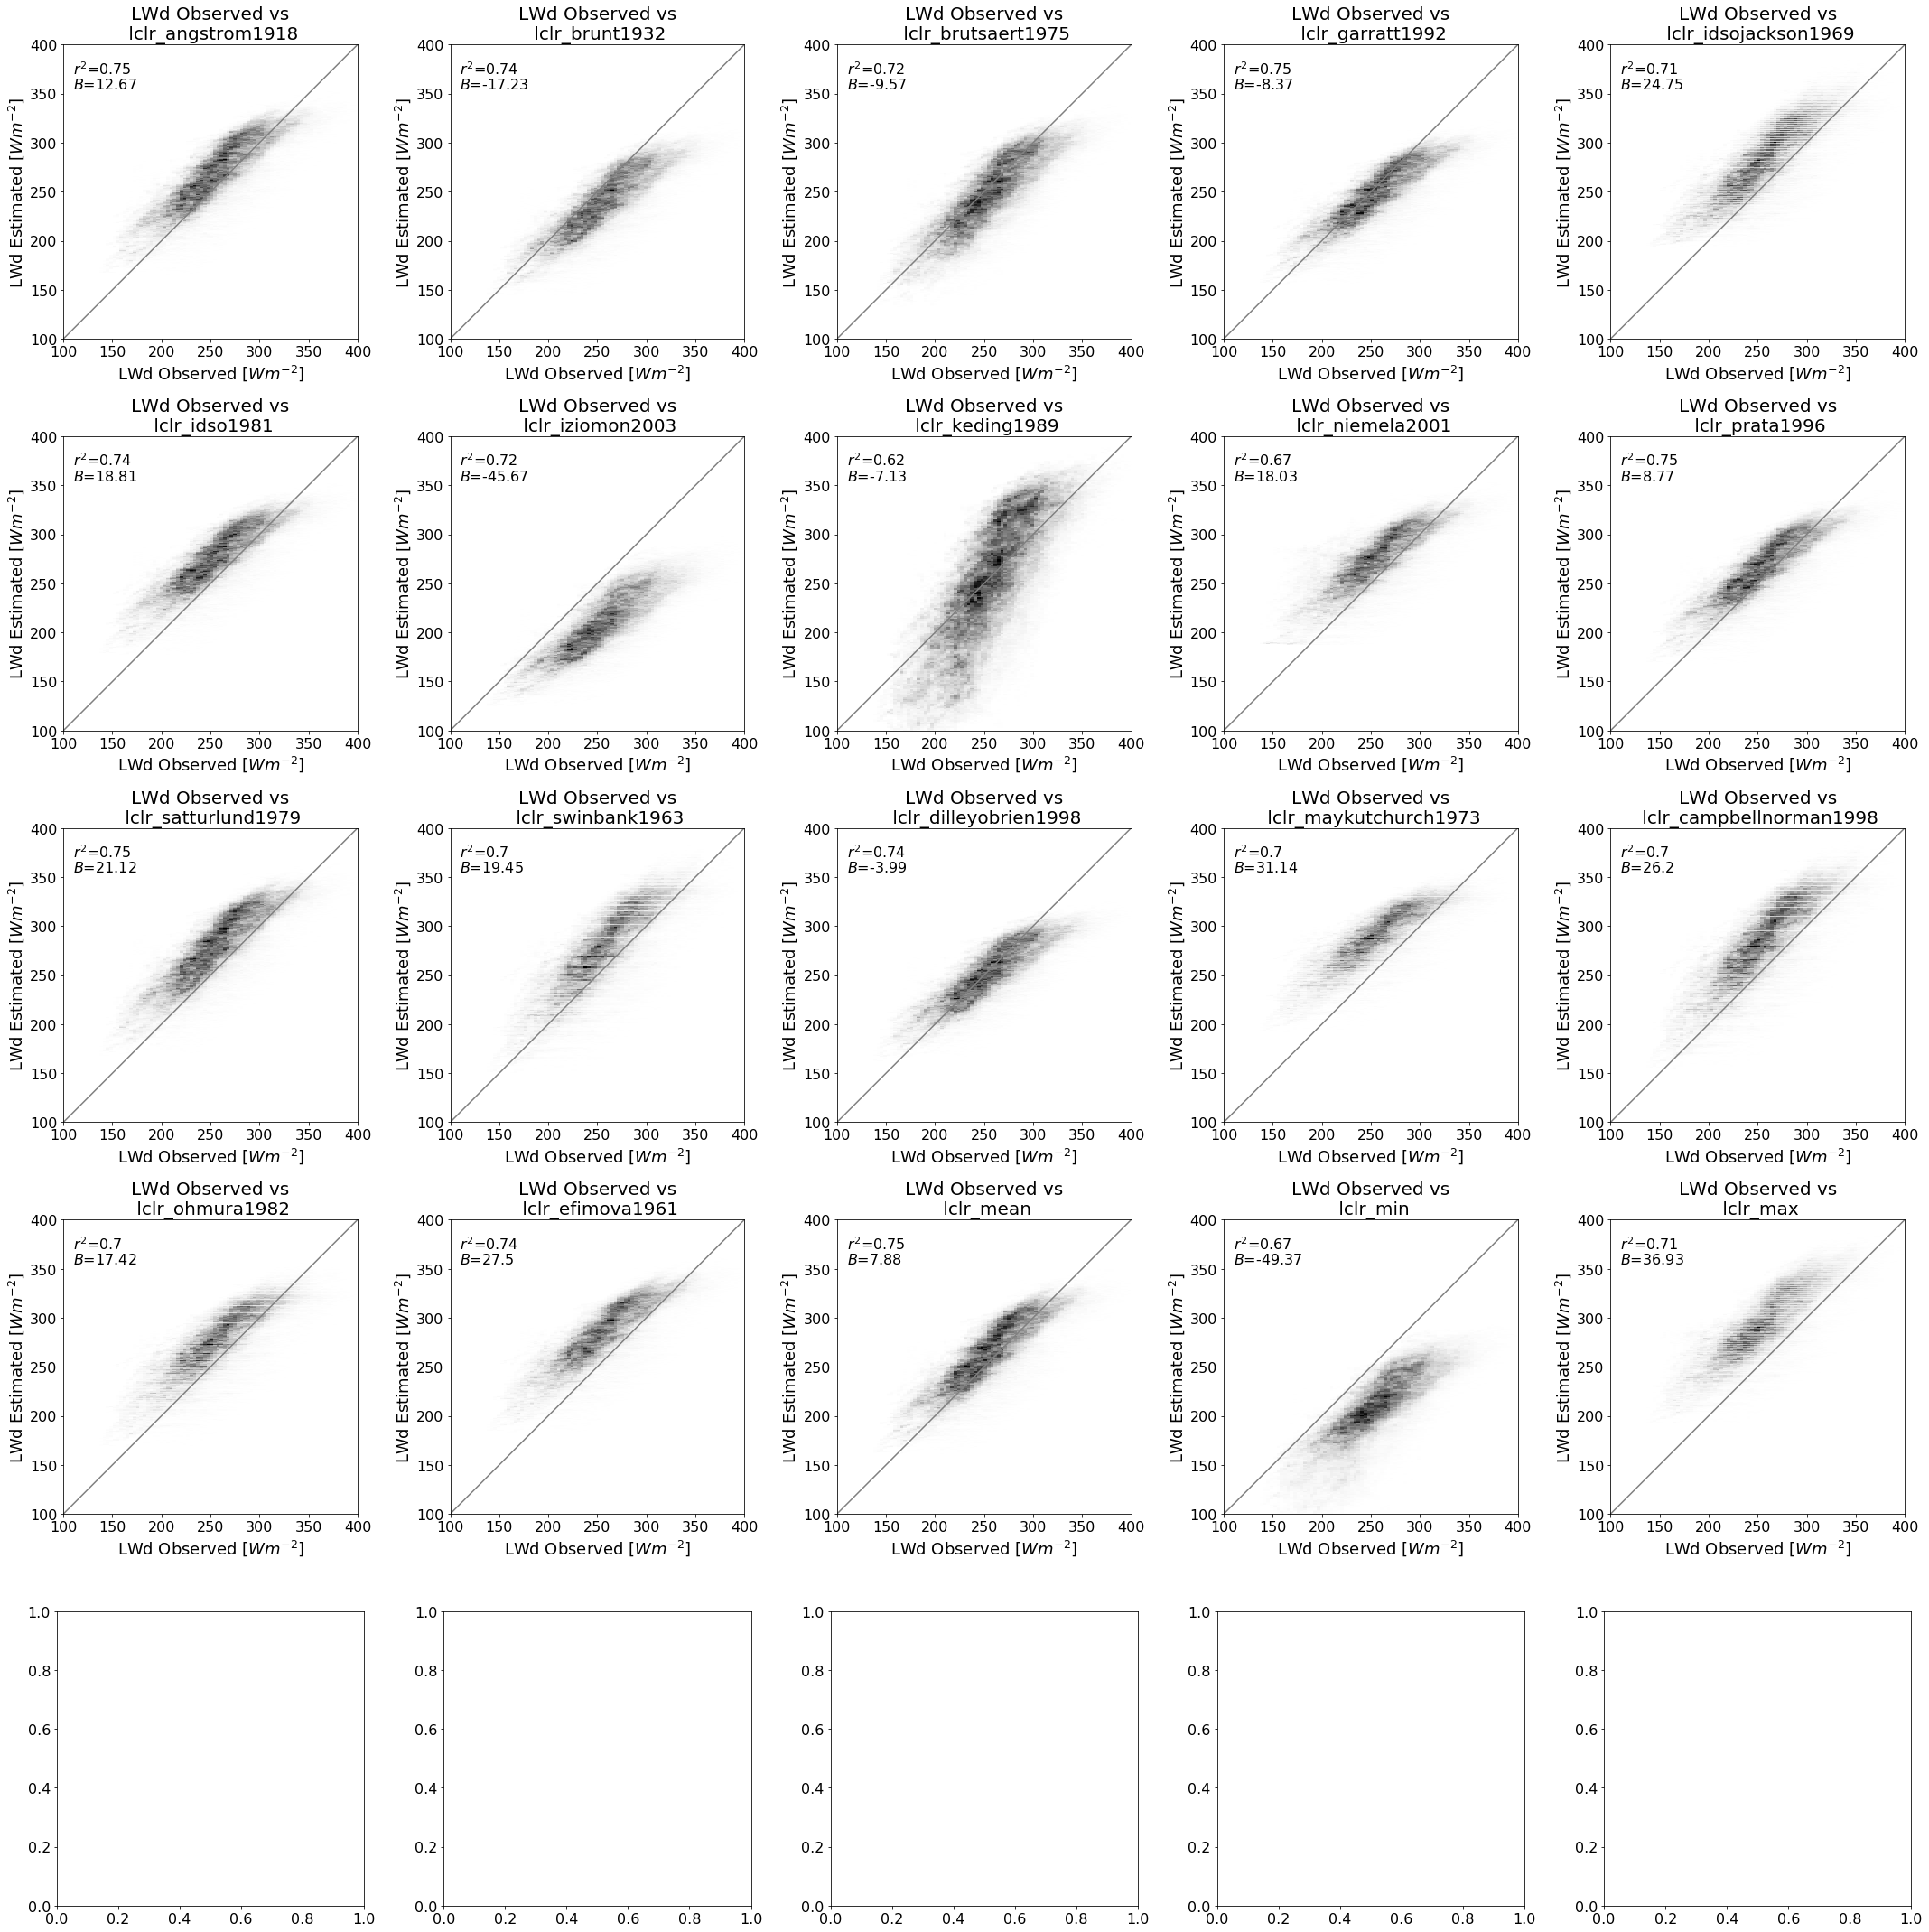

In [13]:
fig, ax = plt.subplots(5,5,figsize=(30,30))
for row in range(0,5):
    for col in range(0,5):
        try:
            plot_2dhist_LWensemble(x.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                                   y[(row*5)+col].where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1)
                                   ,row,col)
        except IndexError:
            pass
plt.tight_layout()

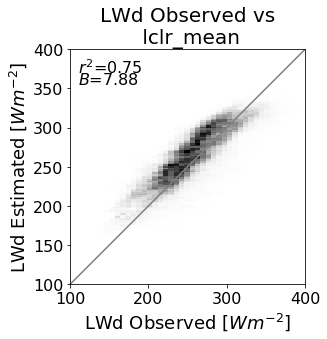

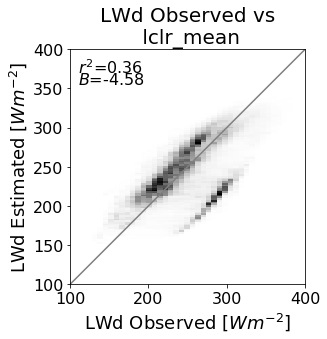

In [14]:
fig, ax = plt.subplots(figsize=(5,5))
plot_2dhist_LW(x.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1),
                cues_ds.lclr_mean.where(cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)']==1))

plt.tight_layout()


fig, ax = plt.subplots(figsize=(5,5))

plot_2dhist_LW(x,cues_ds.lclr_mean)

plt.tight_layout()



Make a cloud flag where we think there's cloud cover

In [15]:
threshold = 25 # threshold above ensemble mean [W^m-2]
cloud_flag = np.zeros_like(cues_ds.lclr_mean.values)
lw_cloud_condition = cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'] > cues_ds.lclr_mean + threshold
cloud_flag[lw_cloud_condition] = 1
cues_ds['cloud_flag'] = (['datetime'],  cloud_flag)

In [16]:
cues_ds['cloud_flag'] = (['datetime'],  cloud_flag)

Pickle this out as a pandas dataframe:

In [17]:
cues_ds.to_dataframe().to_pickle('CUES_L1_Temp_Rad_2017-2019_lw.pkl')

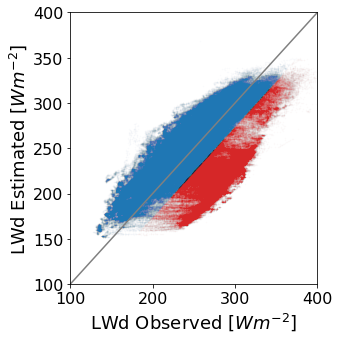

In [18]:
fig, ax = plt.subplots(figsize=(5,5))

ax.scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].where(cues_ds.cloud_flag==1),
           cues_ds.lclr_mean.where(cues_ds.cloud_flag==1),
          s=1, c='tab:red', alpha=0.01, label='observed > clear-sky')

ax.scatter(cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].where(cues_ds.cloud_flag==0),
           cues_ds.lclr_mean.where(cues_ds.cloud_flag==0),
          s=1, c='tab:blue', alpha=0.01, label='observed <= clear-sky')



ax.plot([0,400],[0,400],'-',c='grey')
#ax.text(110,370,'$r^2$={}'.format(np.round(r_value**2,2)))
#ax.text(110,355,'$B$={}'.format(np.round(np.mean(y)-np.mean(x),2)))
ax.set_xlim([100,400])
ax.set_ylim([100,400])
ax.set_ylabel('LWd Estimated [$Wm^{-2}$]')
ax.set_xlabel('LWd Observed [$Wm^{-2}$]');
#ax.set_title('LWd Observed vs\n {}'.format(y_.name))

plt.tight_layout()

Plot some results zoomed in to a couple days:

C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  
C:\Users\steve\Anaconda3\envs\rasterenv\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  This is separate from the ipykernel package so we can avoid doing imports until


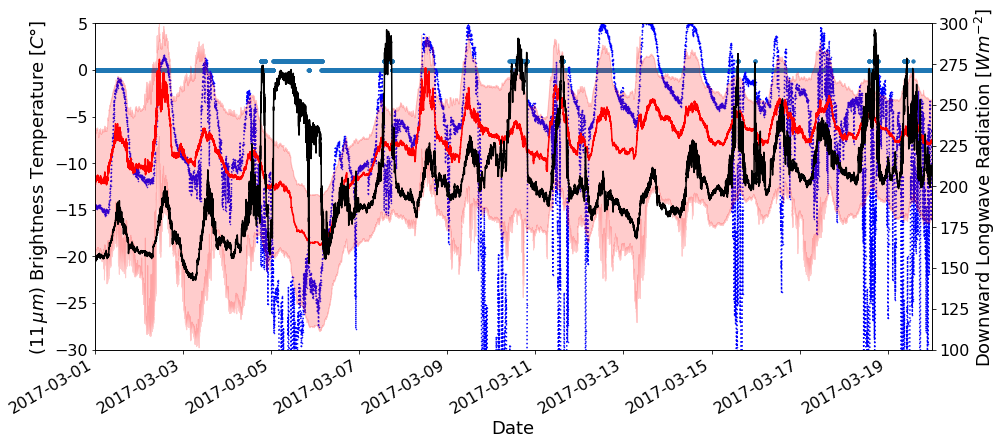

In [19]:
# Set start and end dates for time period we want to look at
startdate = pd.datetime(2017,3,1)
enddate = pd.datetime(2017,3,20)

fig, ax = plt.subplots(figsize=(15,6))


ax2 = ax.twinx()


lw_ensemble.lclr_mean.plot(ax=ax2,alpha=1,c='r')
ax2.fill_between(lw_ensemble.datetime, lw_ensemble.lclr_max, lw_ensemble.lclr_min,color='r',alpha=0.2)


# Observed Downward Lognwave Radiation
cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)'].plot(ax=ax2, c='k')
cues_ds.cloud_flag.plot(ax=ax,linestyle='none',marker='.')

# Fill in areas CUES identifies as sunny versus not sunny
#sun_flag = cues_rad['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1
#cues_nosun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=~sun_flag, color='lightgrey',alpha=0.1)
#cues_sun = ax2.fill_between(cues_rad_data.datetime, 1000, y2=0, where=sun_flag, color='lightyellow',alpha=0.1)
#
#cloud_flag = cues_ds['Lclr'] < cues_rad['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']
#cloud = ax.fill_between(cues_rad_data.datetime, 1000, y2=0, where=cloud_flag, color='red',alpha=0.1)

# GOES brightness temperature
goes_ds.tb.plot(c='b', linestyle=':', marker='.', markersize=1, ax=ax)

#ax.set_xlim((cues_rad.datetime.min(),cues_rad.datetime.max()))
ax.set_xlim([startdate,enddate])
ax2.set_ylim((100,300))
ax.set_ylim((-30,5))

ax.set_ylabel('($11 \, \mu m$) Brightness Temperature [$C\degree$]')
ax.set_xlabel('Date')
ax2.set_ylabel('Downward Longwave Radiation [$W m^{-2}$]');

# make legend
#lines = [ax.lines[0], ax2.lines[0], ax2.lines[1]]
#labels = ['GOES Brightness Temp.', 'Clear-Sky Downward LW', 'CUES: Downward LW']
#ax.legend(lines, labels, loc='upper left')

---
---